# Aula 10 - Computational Tradeoffs

[Unicamp - IA368DD: Deep Learning aplicado a sistemas de busca.](https://www.cpg.feec.unicamp.br/cpg/lista/caderno_horario_show.php?id=1779)

Autor: Marcus Vinícius Borela de Castro

[Repositório no github](https://github.com/marcusborela/deep_learning_em_buscas_unicamp)


# Enunciado exercício



Exercício desta semana: Trade-offs de eficiência e qualidade

O objetivo do exercício desta semana é construir alguns pipelines de busca e analisá-los em termos das seguintes métricas:
Qualidade dos resultados: nDCG@10;
Latência (seg/query);
USD por query assumindo utilização "perfeita": assim que terminou de processar uma query, já tem outra para ser processada;
USD/mês para deixar o sistema rodando para poucos usuários (ex: 100 queries/dia);
Custo de indexação em USD;

Iremos avaliar os pipelines no TREC-COVID.
A latência precisa ser menor que 2 segundos por query.
Não assumir processamento de queries em batch.

Considerar:
1,50 USD/hora por A100 ou 0,21 USD/hora por T4 ou 0,50 USD/hora por V100
0,03 USD/hora por CPU core
0,005 USD/hora por GB de CPU RAM
Dicas:
Utilizar modelos de busca "SOTA" já treinados no MS MARCO como parte do pipeline, como o SPLADE distil (esparso), contriever (denso), Colbert-v2 (denso), miniLM (reranker), monoT5-3B (reranker), doc2query minus-minus (expansão de documentos + filtragem com reranqueador na etapa de indexação)
Pode usar API's como Cohere, OpenAI Embeddings

Variar parâmetros como número de documentos retornados em cada estágio. Por exemplo, BM25 retorna 1000 documentos, um modelo denso ou esparso pode franqueá-los, e passar os top 50 para o miniLM/monoT5 fazer um ranqueamento final.



# Organizando o ambiente

## Importações

In [1]:
import pandas as pd

In [2]:
from tqdm import tqdm

In [3]:
import os

In [4]:
import pickle

In [5]:
import time

In [6]:
import numpy as np

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
DIRETORIO_LOCAL = '/home/borela/fontes/deep_learning_em_buscas_unicamp/local'
DIRETORIO_TRABALHO = F'{DIRETORIO_LOCAL}/tradeoff'
PATH_RESULTADO_PIPELINE = f"{DIRETORIO_TRABALHO}/resultado_pipeline.pickle"
PATH_AVALIACAO_CONTEXTO_PIPELINE = f"{DIRETORIO_TRABALHO}/avaliacao_contexto_pipeline.pickle"
PATH_RESULTADO_PIPELINE_SPLADE = f"{DIRETORIO_TRABALHO}/resultado_pipeline_splade.pickle"
PATH_AVALIACAO_CONTEXTO_PIPELINE_SPLADE = f"{DIRETORIO_TRABALHO}/avaliacao_contexto_pipeline_splade.pickle"

# Carga dos resultados para novas avaliações

In [8]:
with open(PATH_RESULTADO_PIPELINE, 'rb') as f:
    resultado_pipeline = pickle.load(f)

In [9]:
with open(PATH_AVALIACAO_CONTEXTO_PIPELINE, 'rb') as f:
    avaliacao_pipeline_contexto = pickle.load(f)

In [10]:
with open(PATH_RESULTADO_PIPELINE_SPLADE, 'rb') as f:
    resultado_pipeline_splade = pickle.load(f)

In [11]:
with open(PATH_AVALIACAO_CONTEXTO_PIPELINE_SPLADE, 'rb') as f:
    avaliacao_pipeline_contexto_splade = pickle.load(f)

In [15]:
resultado_pipeline = resultado_pipeline | resultado_pipeline_splade

In [17]:
avaliacao_pipeline_contexto = avaliacao_pipeline_contexto | avaliacao_pipeline_contexto_splade

In [18]:
len(resultado_pipeline), len(avaliacao_pipeline_contexto)

(12, 12)

In [20]:
resultado_pipeline

{'bm25': {'tempo_indexacao_segundo': [{'tipo': 'cpu', 'valor': 0.109634}],
  'memoria_indice_byte_ram': 269772727,
  'se_retrieval_usa_gpu': False,
  'retrieval_tempo_medio_por_query': 0.044992,
  'ndcg_10': 61.88},
 'bm25@100_reranking_minilm': {'tempo_indexacao_segundo': [{'tipo': 'cpu',
    'valor': 0.109634}],
  'memoria_indice_byte_ram': 269772727,
  'se_retrieval_usa_gpu': True,
  'retrieval_tempo_medio_por_query': 0.279581,
  'ndcg_10': 74.85},
 'bm25@500_reranking_minilm': {'tempo_indexacao_segundo': [{'tipo': 'cpu',
    'valor': 0.109634}],
  'memoria_indice_byte_ram': 269772727,
  'se_retrieval_usa_gpu': True,
  'retrieval_tempo_medio_por_query': 1.347039,
  'ndcg_10': 71.47},
 'bm25@50_reranking_monobert': {'tempo_indexacao_segundo': [{'tipo': 'cpu',
    'valor': 0.109634}],
  'memoria_indice_byte_ram': 269772727,
  'se_retrieval_usa_gpu': True,
  'retrieval_tempo_medio_por_query': 1.255988,
  'ndcg_10': 70.97},
 'bm25@70_reranking_monobert': {'tempo_indexacao_segundo': [{'t

In [21]:
avaliacao_pipeline_contexto

{'bm25': {'utilizacao_perfeita': {'usd_query': 3.906e-07,
   'usd_dia': 0.750145483605888,
   'usd_gpu_dia': 0,
   'usd_mes': 22.50436450817664,
   'usd_indexacao_tempo': 9.135801219999999e-07},
  'utilizacao_precaria_100': {'usd_query': 0.0075014548,
   'usd_dia': 0.750145483605888,
   'usd_gpu_dia': 0,
   'usd_mes': 22.50436450817664,
   'usd_indexacao_tempo': 9.135801219999999e-07}},
 'bm25@100_reranking_minilm': {'utilizacao_perfeita': {'usd_query': 2.18415e-05,
   'usd_dia': 6.749761483605887,
   'usd_gpu_dia': 5.999616,
   'usd_mes': 202.49284450817663,
   'usd_indexacao_tempo': 9.135801219999999e-07},
  'utilizacao_precaria_100': {'usd_query': 0.0075208689,
   'usd_dia': 0.7520868940698879,
   'usd_gpu_dia': 0.001941410464,
   'usd_mes': 22.562606822096637,
   'usd_indexacao_tempo': 9.135801219999999e-07}},
 'bm25@500_reranking_minilm': {'utilizacao_perfeita': {'usd_query': 0.0001052337,
   'usd_dia': 6.749761483605887,
   'usd_gpu_dia': 5.999616,
   'usd_mes': 202.4928445081766

# Tratando dados para gráficos

In [32]:
# Criação dos dados para o gráfico
data_resultado = []
for key, value in resultado_pipeline.items():
    tempo_indexacao_gpu = 0
    tempo_indexacao_cpu = 0
    for item in value['tempo_indexacao_segundo']:
        # print(item)
        if 'cpu' == item['tipo']: 
            tempo_indexacao_cpu += item['valor']
        if 'gpu' == item['tipo']: 
             tempo_indexacao_gpu += item['valor']
    # print(tempo_indexacao_cpu, tempo_indexacao_gpu)
    data_resultado.append({
        'pipeline' : key,
        'ndcg_10': value['ndcg_10'],
        'retrieval_tempo_medio_por_query': value['retrieval_tempo_medio_por_query'],
        'se_retrieval_usa_gpu': value['se_retrieval_usa_gpu'],
        'memoria_indice_byte_ram': value['memoria_indice_byte_ram'],
        'tempo_indexacao_cpu': tempo_indexacao_cpu,
        'tempo_indexacao_gpu': tempo_indexacao_gpu,
    })


In [33]:
df_resultado = pd.DataFrame(data_resultado)

In [34]:
df_resultado

,pipeline,ndcg_10,retrieval_tempo_medio_por_query,se_retrieval_usa_gpu,memoria_indice_byte_ram,tempo_indexacao_cpu,tempo_indexacao_gpu
0,bm25,61.88,0.044992,False,269772727,0.109634,0
1,bm25@100_reranking_minilm,74.85,0.279581,True,269772727,0.109634,0
2,bm25@500_reranking_minilm,71.47,1.347039,True,269772727,0.109634,0
3,bm25@50_reranking_monobert,70.97,1.255988,True,269772727,0.109634,0
4,bm25@70_reranking_monobert,71.25,1.722126,True,269772727,0.109634,0
5,splade_cocondenser_max_com_sep,72.14,0.104524,True,123765204,0.000000,1470
6,splade_cocondenser_max_sem_sep,72.00,0.058798,True,121051960,0.000000,1456
7,splade_cocondenser_max_com_sep_sem_exp_query_l...,17.13,0.040139,False,587578693,3053.000000,1470
8,splade_max_com_sep_sem_exp_query_lucene,17.13,0.042195,False,587578693,2669.000000,1470
9,splade_max_com_sep_sem_exp_query_lucene_texto_exp,42.31,0.052678,False,784228554,2688.000000,1470


In [63]:
ndcg10_pipe = df_resultado.set_index('pipeline')['ndcg_10'].to_dict()


In [65]:
se_usa_gpu_pipe = df_resultado.set_index('pipeline')['se_retrieval_usa_gpu'].to_dict()


In [92]:
retrieval_tempo_medio_por_query_pipe = df_resultado.set_index('pipeline')['retrieval_tempo_medio_por_query'].to_dict()

In [64]:
ndcg10_pipe['splade_cocondenser_max_com_sep']

72.14

In [118]:
import math

In [125]:
# Criação dos dados para o gráfico
data_avaliacao_contexto = []
for key_pipe, value_pipe in avaliacao_pipeline_contexto.items():

    for key_contexto, value_contexto in value_pipe.items():
        if key_contexto == 'utilizacao_perfeita':
            num_queries_dia = math.floor((24 * 60 * 60) / retrieval_tempo_medio_por_query_pipe[key_pipe])
        elif key_contexto == 'utilizacao_precaria_100':
            num_queries_dia = 100
        data_avaliacao_contexto.append({
            'pipeline' : key_pipe,
            'contexto' : key_contexto,
            'ndcg_10': ndcg10_pipe[key_pipe],
            'se_retrieval_usa_gpu': se_usa_gpu_pipe[key_pipe],
            'num_queries_dia': num_queries_dia,
            'usd_dia': value_contexto['usd_dia'],
            'usd_gpu_dia': value_contexto['usd_gpu_dia'],
            'usd_query': value_contexto['usd_dia']/num_queries_dia,  # custo dia já tem custo cpu + gpu para as chamadas de queries (se for o caso)
            'usd_mes': value_contexto['usd_mes'],
            'usd_indexacao_tempo': value_contexto['usd_indexacao_tempo'],
        })


In [126]:
df_avaliacao_contexto = pd.DataFrame(data_avaliacao_contexto)

In [127]:
df_avaliacao_contexto

,pipeline,contexto,ndcg_10,se_retrieval_usa_gpu,num_queries_dia,usd_dia,usd_gpu_dia,usd_query,usd_mes,usd_indexacao_tempo
0,bm25,utilizacao_perfeita,61.88,False,1920341,0.750145,0.000000,3.906314e-07,22.504365,9.135801e-07
1,bm25,utilizacao_precaria_100,61.88,False,100,0.750145,0.000000,7.501455e-03,22.504365,9.135801e-07
2,bm25@100_reranking_minilm,utilizacao_perfeita,74.85,True,309033,6.749761,5.999616,2.184156e-05,202.492845,9.135801e-07
3,bm25@100_reranking_minilm,utilizacao_precaria_100,74.85,True,100,0.752087,0.001941,7.520869e-03,22.562607,9.135801e-07
4,bm25@500_reranking_minilm,utilizacao_perfeita,71.47,True,64140,6.749761,5.999616,1.052348e-04,202.492845,9.135801e-07
5,bm25@500_reranking_minilm,utilizacao_precaria_100,71.47,True,100,0.759499,0.009354,7.594993e-03,22.784980,9.135801e-07
6,bm25@50_reranking_monobert,utilizacao_perfeita,70.97,True,68790,6.749761,5.999616,9.812126e-05,202.492845,9.135801e-07
7,bm25@50_reranking_monobert,utilizacao_precaria_100,70.97,True,100,0.758867,0.008722,7.588671e-03,22.766012,9.135801e-07
8,bm25@70_reranking_monobert,utilizacao_perfeita,71.25,True,50170,6.749761,5.999616,1.345378e-04,202.492845,9.135801e-07
9,bm25@70_reranking_monobert,utilizacao_precaria_100,71.25,True,100,0.762104,0.011958,7.621039e-03,22.863118,9.135801e-07


# Gerando gráficos para trade-off de recursos dos pipelines


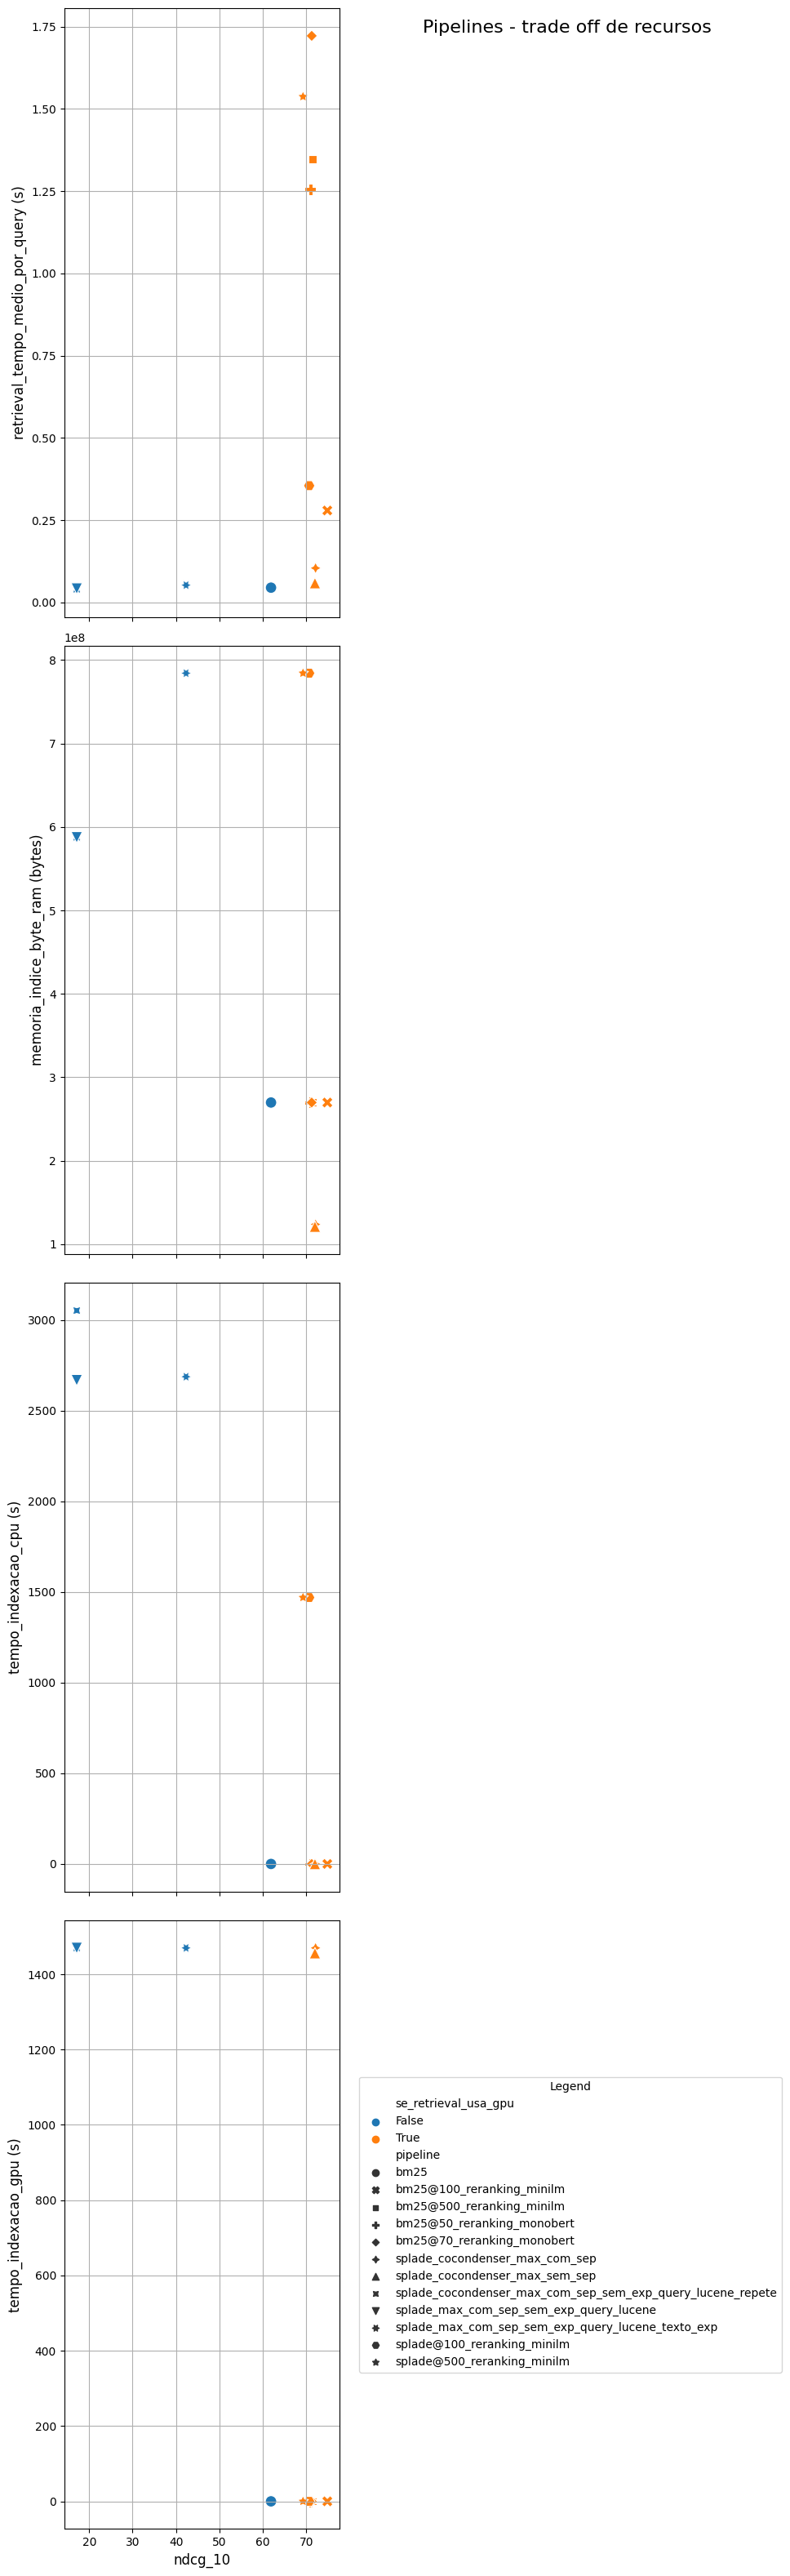

In [100]:
import matplotlib.pyplot as plt

# Itera sobre as métricas e cria os subplots correspondentes
metrics = ['retrieval_tempo_medio_por_query', 'memoria_indice_byte_ram', 'tempo_indexacao_cpu', 'tempo_indexacao_gpu']

# Criação da grade de subplots
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 32), sharex=True)

# Configurações globais dos subplots
fig.suptitle('Pipelines - trade off de recursos', fontsize=16, x=0.7)
# axs[0].title('Avaliando Pipelines - trade off', fontsize=16)
plt.xlabel('ndcg_10', fontsize=12)


# Criação do gráfico usando seaborn
# sns.scatterplot(data=df_resultado, x='ndcg_10', y='retrieval_tempo_medio_por_query', hue='se_retrieval_usa_gpu', style='pipeline', s=100)


for i, metric in enumerate(metrics):
    # sns.scatterplot(data=df_resultado, x='ndcg_10', y=metric, hue='se_retrieval_usa_gpu', ax=axs[i], s=100, palette='viridis')
    if i == len(metrics)-1:
        sns.scatterplot(data=df_resultado, x='ndcg_10', legend=True, y=metric, ax=axs[i], hue='se_retrieval_usa_gpu', style='pipeline', s=100)# , palette='viridis')
        plt.legend(title='Legend', bbox_to_anchor=(1.05, 0.5), loc='center left')
    else: 
        sns.scatterplot(data=df_resultado, x='ndcg_10', legend=False, y=metric, ax=axs[i], hue='se_retrieval_usa_gpu', style='pipeline', s=100)#, palette='viridis')
    if 'tempo' in metric:
        metric_legend = metric + ' (s)'
    if 'memoria' in metric:
        metric_legend = metric + ' (bytes)'
    axs[i].set_ylabel(metric_legend, fontsize=12)
    axs[i].grid(True)
    # Mostra a legenda fora do gráfico
    # axs[i].legend(loc='center right', bbox_to_anchor=(1.8, 0.5), title='Legend')




# Configurações adicionais
plt.tight_layout()

# Mostra os gráficos
plt.show()


# Gerando gráficos para trade-off de custo em contextos de uso dos pipelines


In [128]:
df_avaliacao_contexto.head()

,pipeline,contexto,ndcg_10,se_retrieval_usa_gpu,num_queries_dia,usd_dia,usd_gpu_dia,usd_query,usd_mes,usd_indexacao_tempo
0,bm25,utilizacao_perfeita,61.88,False,1920341,0.750145,0.000000,3.906314e-07,22.504365,9.135801e-07
1,bm25,utilizacao_precaria_100,61.88,False,100,0.750145,0.000000,7.501455e-03,22.504365,9.135801e-07
2,bm25@100_reranking_minilm,utilizacao_perfeita,74.85,True,309033,6.749761,5.999616,2.184156e-05,202.492845,9.135801e-07
3,bm25@100_reranking_minilm,utilizacao_precaria_100,74.85,True,100,0.752087,0.001941,7.520869e-03,22.562607,9.135801e-07
4,bm25@500_reranking_minilm,utilizacao_perfeita,71.47,True,64140,6.749761,5.999616,1.052348e-04,202.492845,9.135801e-07


In [106]:
texto_contexto_parametro = {}
texto_contexto_parametro['utilizacao_perfeita'] = 'uso perfeito (queries seguidas)'
texto_contexto_parametro['utilizacao_precaria_100'] = 'uso precário (100 queries/dia)'

for key_contexto, texto_contexto in texto_contexto_parametro.items():
    print(key_contexto, texto_contexto)

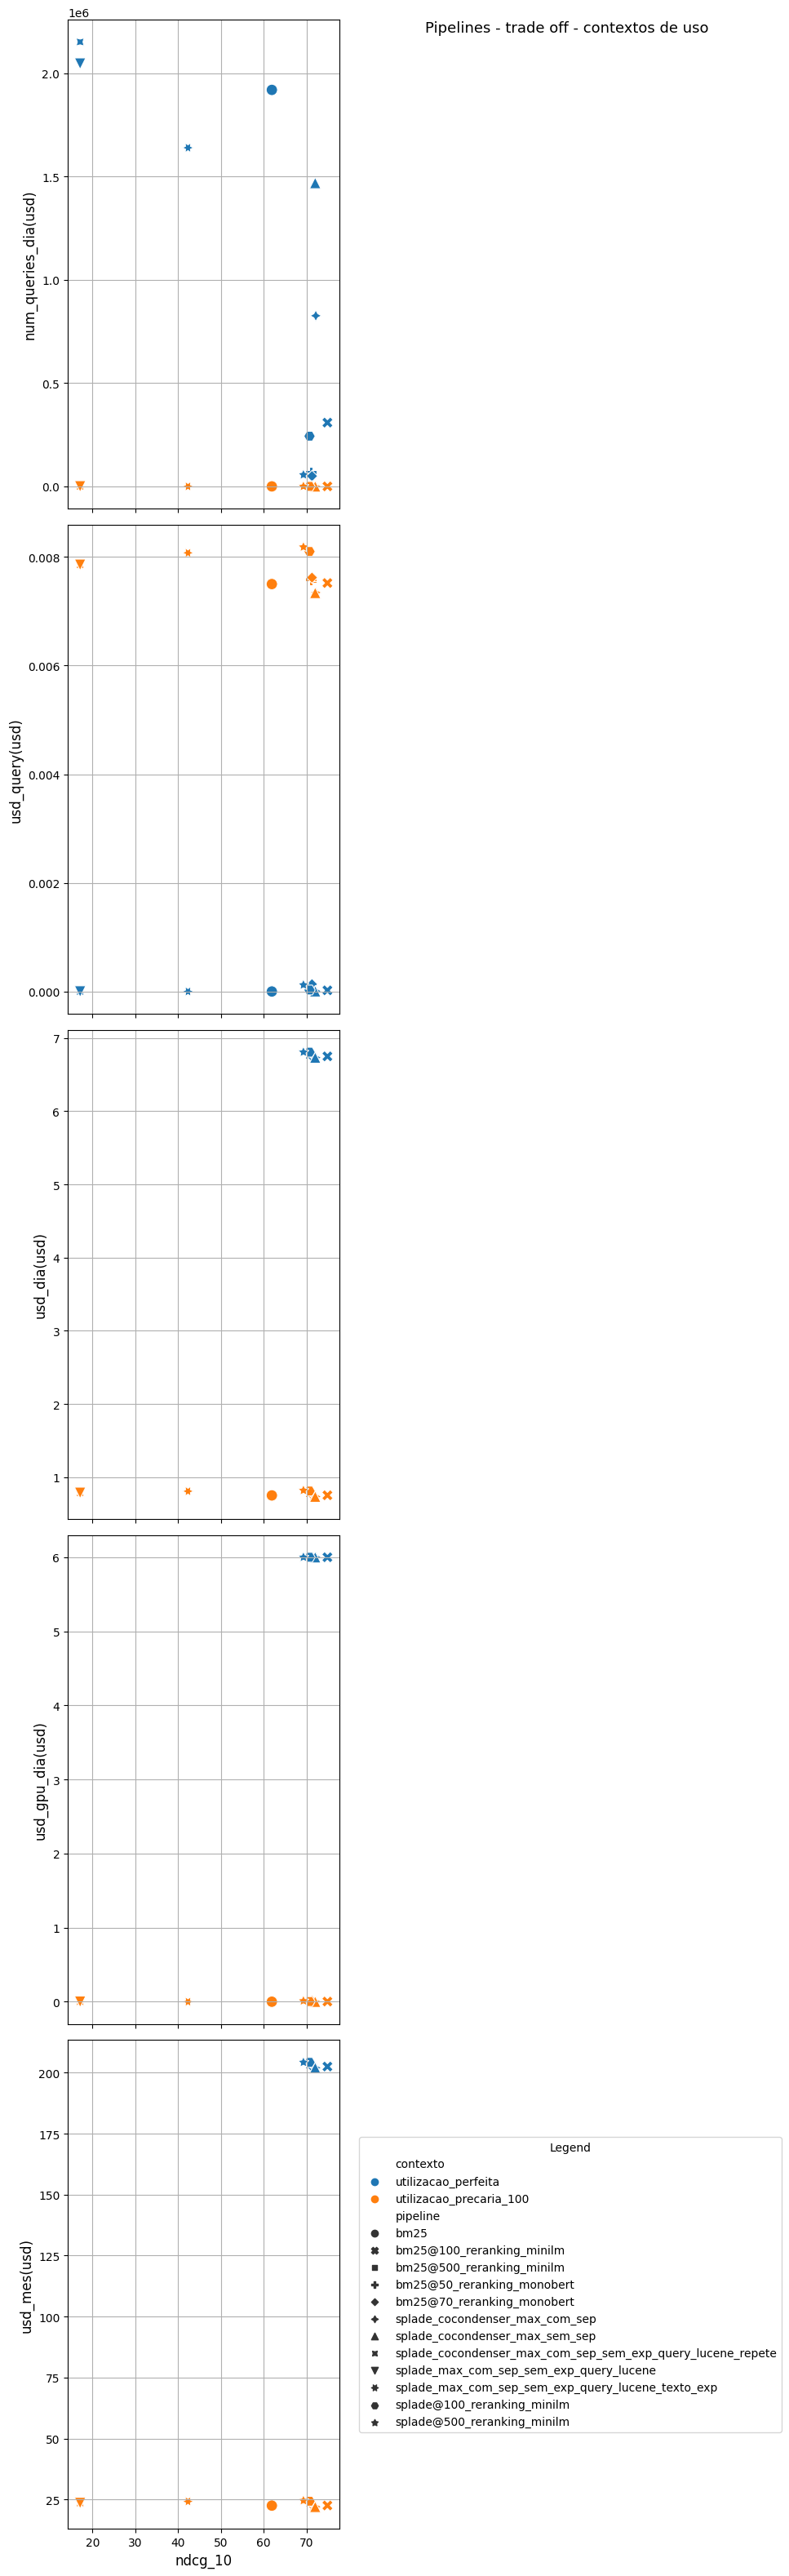

In [129]:
# Itera sobre as métricas e cria os subplots correspondentes
metrics = ['num_queries_dia', 'usd_query', 'usd_dia', 'usd_gpu_dia', 'usd_mes']

# Criação da grade de subplots
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 32), sharex=True)

# Configurações globais dos subplots
fig.suptitle(f'Pipelines - trade off - contextos de uso', fontsize=13, x=0.7)
# axs[0].title('Avaliando Pipelines - trade off', fontsize=16)
plt.xlabel('ndcg_10', fontsize=12)


# Criação do gráfico usando seaborn
# sns.scatterplot(data=df_grafico, x='ndcg_10', y='retrieval_tempo_medio_por_query', hue='se_retrieval_usa_gpu', style='pipeline', s=100)


for i, metric in enumerate(metrics):
    # sns.scatterplot(data=df_resultado, x='ndcg_10', y=metric, hue='se_retrieval_usa_gpu', ax=axs[i], s=100, palette='viridis')
    if i == len(metrics)-1:
        sns.scatterplot(data=df_avaliacao_contexto, x='ndcg_10', legend=True, y=metric, ax=axs[i], hue='contexto', style='pipeline', s=100)# , palette='viridis')
        plt.legend(title='Legend', bbox_to_anchor=(1.05, 0.5), loc='center left')
    else: 
        sns.scatterplot(data=df_avaliacao_contexto, x='ndcg_10', legend=False, y=metric, ax=axs[i], hue='contexto', style='pipeline', s=100)#, palette='viridis')
    axs[i].set_ylabel(metric + '(usd)', fontsize=12)
    axs[i].grid(True)
    # Mostra a legenda fora do gráfico
    # axs[i].legend(loc='center right', bbox_to_anchor=(1.8, 0.5), title='Legend')




# Configurações adicionais
plt.tight_layout()

# Mostra os gráficos
plt.show()


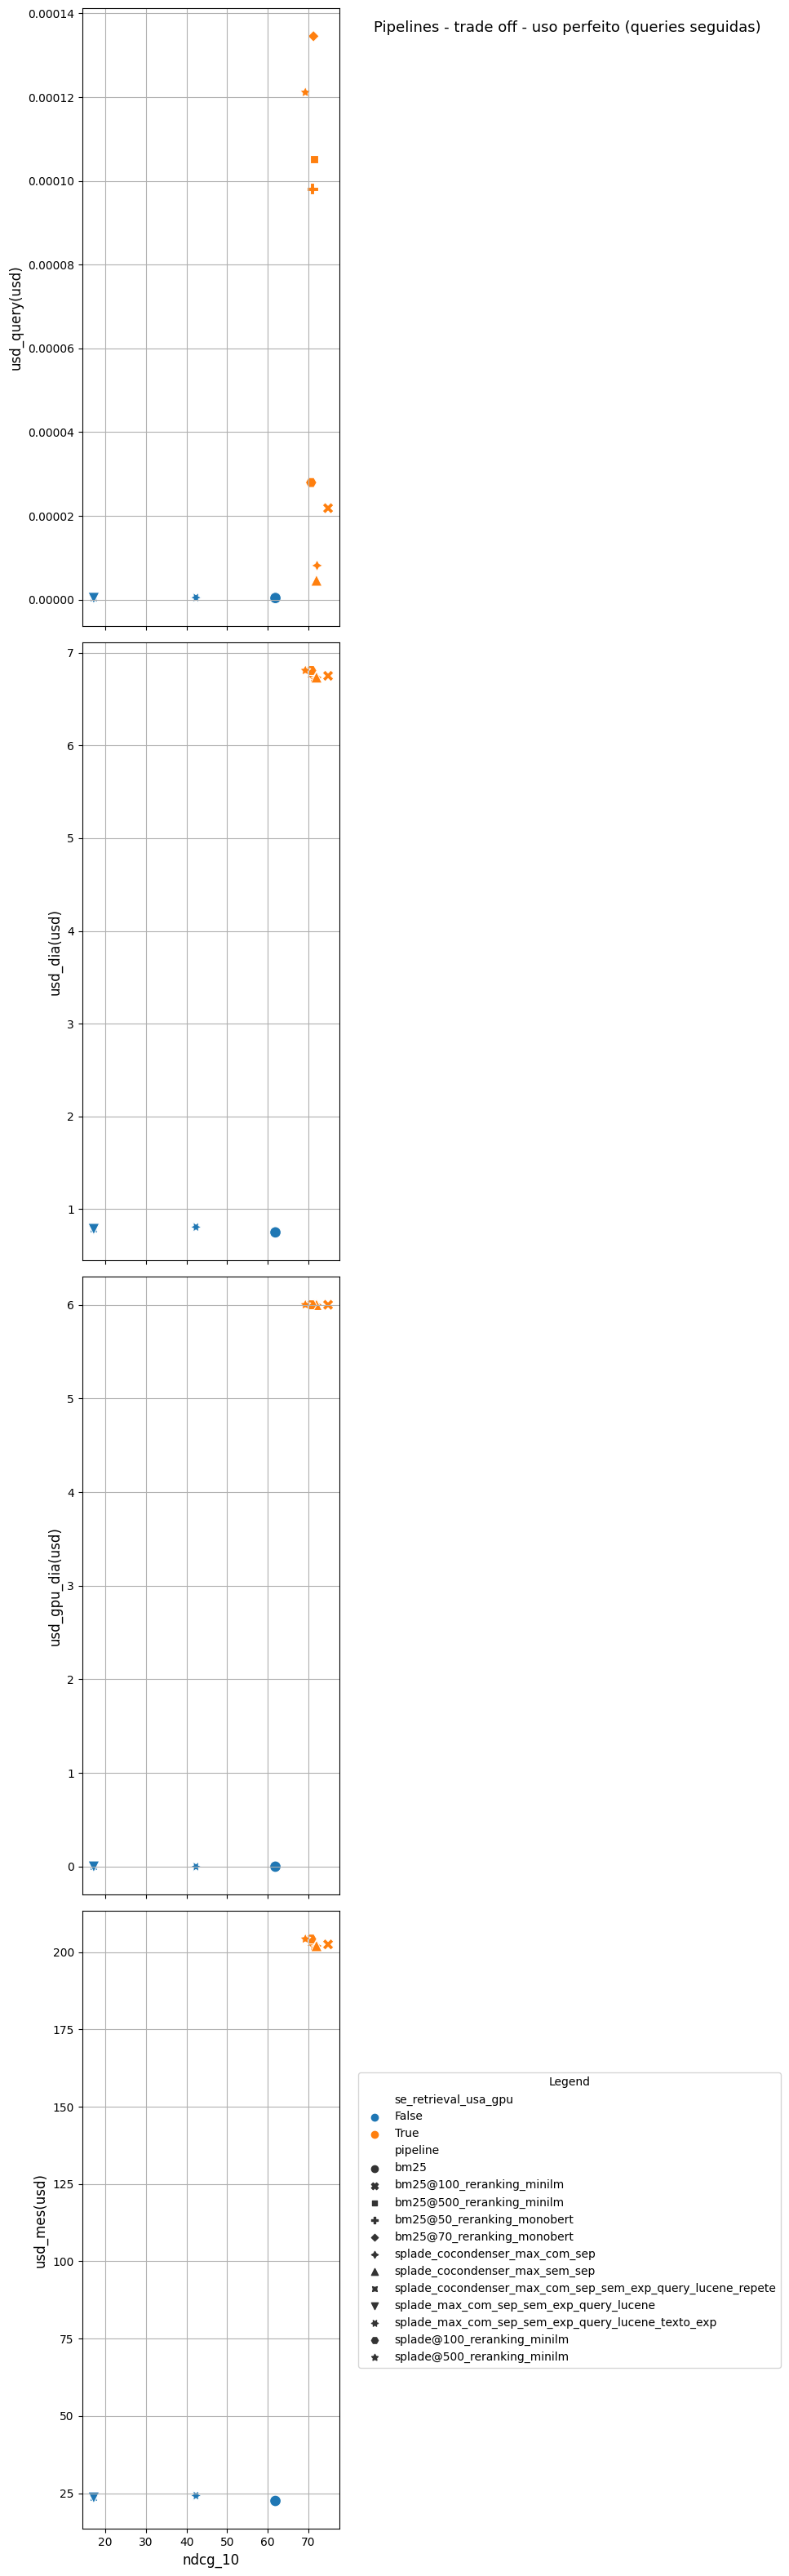

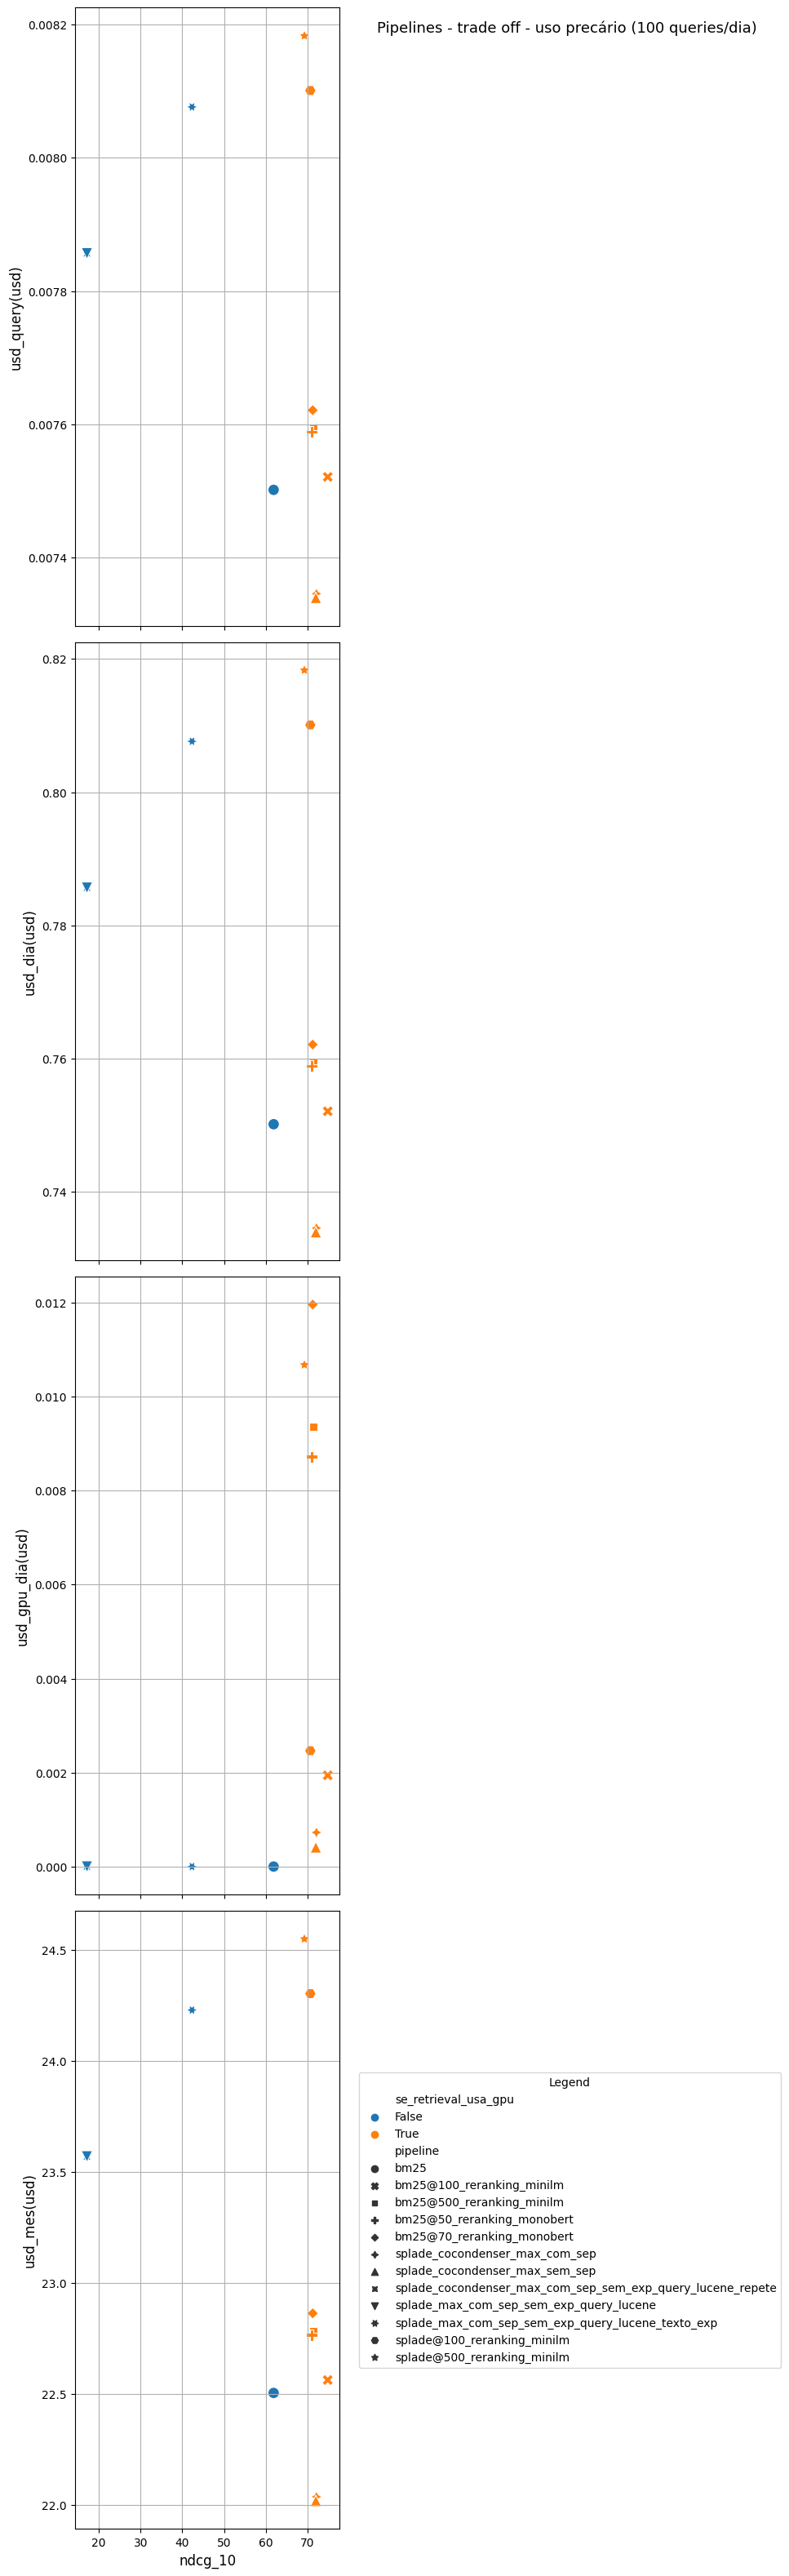

In [130]:
for key_contexto, texto_contexto in texto_contexto_parametro.items():

    df_grafico = df_avaliacao_contexto[df_avaliacao_contexto['contexto']==key_contexto]

    # Itera sobre as métricas e cria os subplots correspondentes
    metrics = ['usd_query', 'usd_dia', 'usd_gpu_dia', 'usd_mes']

    # Criação da grade de subplots
    fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 32), sharex=True)

    # Configurações globais dos subplots
    fig.suptitle(f'Pipelines - trade off - {texto_contexto}', fontsize=13, x=0.7)
    # axs[0].title('Avaliando Pipelines - trade off', fontsize=16)
    plt.xlabel('ndcg_10', fontsize=12)


    # Criação do gráfico usando seaborn
    # sns.scatterplot(data=df_grafico, x='ndcg_10', y='retrieval_tempo_medio_por_query', hue='se_retrieval_usa_gpu', style='pipeline', s=100)


    for i, metric in enumerate(metrics):
        # sns.scatterplot(data=df_resultado, x='ndcg_10', y=metric, hue='se_retrieval_usa_gpu', ax=axs[i], s=100, palette='viridis')
        if i == len(metrics)-1:
            sns.scatterplot(data=df_grafico, x='ndcg_10', legend=True, y=metric, ax=axs[i], hue='se_retrieval_usa_gpu', style='pipeline', s=100)# , palette='viridis')
            plt.legend(title='Legend', bbox_to_anchor=(1.05, 0.5), loc='center left')
        else: 
            sns.scatterplot(data=df_grafico, x='ndcg_10', legend=False, y=metric, ax=axs[i], hue='se_retrieval_usa_gpu', style='pipeline', s=100)#, palette='viridis')
        axs[i].set_ylabel(metric + '(usd)', fontsize=12)
        axs[i].grid(True)
        # Mostra a legenda fora do gráfico
        # axs[i].legend(loc='center right', bbox_to_anchor=(1.8, 0.5), title='Legend')




    # Configurações adicionais
    plt.tight_layout()

    # Mostra os gráficos
    plt.show()

